# Neural Network capable of predicting FFF properties

***Written by Gerardo A. Mazzei Capote and Zijie Liu***

*Last revision: 02/2023*

In [4]:
# Import dependencies
from matplotlib.pyplot import savefig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
#import shap
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
from numpy.random import seed
seed(0)
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

## Importing, manipulating, and cleaning the data

In [5]:
raw_df = pd.read_csv('data_v4.csv', encoding= 'unicode_escape').drop(columns=['Filepath', 'Avg Temperature [°C]', 'Run', 'Sample', 'Notes'])
a = {"Orientation [°]": "O", "Layer Height [mm]": "hL", "Nozzle Diameter [mm]": "DN",
    "Print Speed [mm/min]":"Uxy", "Avg Filament Speed [mm/s]":"Sm", "Avg Force [g]":"F",
    "Modulus [MPa]":"E","Tensile Stress at Tensile Strength [MPa]":"σt"}
df = raw_df.rename(columns=a)
df.head()

,O,hL,DN,Uxy,Sm,F,E,σt
0,0,0.1,0.3,1200,0.36,870.77,2515.99,38.84
1,0,0.1,0.3,1200,0.43,870.32,2343.66,39.45
2,0,0.1,0.3,1200,0.24,826.45,2654.49,39.62
3,0,0.1,0.3,1200,0.24,793.59,2273.61,39.34
4,0,0.1,0.3,1200,0.24,793.59,3208.57,40.65


### Look for correlations between variables 

In [9]:
sns.set(rc={"figure.dpi":300})
#, 'savefig.dpi':300
# Compute the correlation matrix
correlation_matrix = df.corr().round(2)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
mask = mask[1:, :-1]
corr = correlation_matrix.iloc[1:,:-1].copy()
corr = correlation_matrix.iloc[1:,:-1].copy()
print(corr)

        O    hL    DN   Uxy    Sm     F     E
hL  -0.06  1.00 -0.02 -0.01  0.61  0.60 -0.17
DN   0.06 -0.02  1.00  0.05  0.53 -0.39 -0.26
Uxy  0.04 -0.01  0.05  1.00  0.47  0.39 -0.15
Sm  -0.01  0.61  0.53  0.47  1.00  0.39 -0.30
F    0.04  0.60 -0.39  0.39  0.39  1.00 -0.09
E   -0.19 -0.17 -0.26 -0.15 -0.30 -0.09  1.00
σt  -0.84 -0.08 -0.27 -0.10 -0.18 -0.01  0.35


<AxesSubplot:>

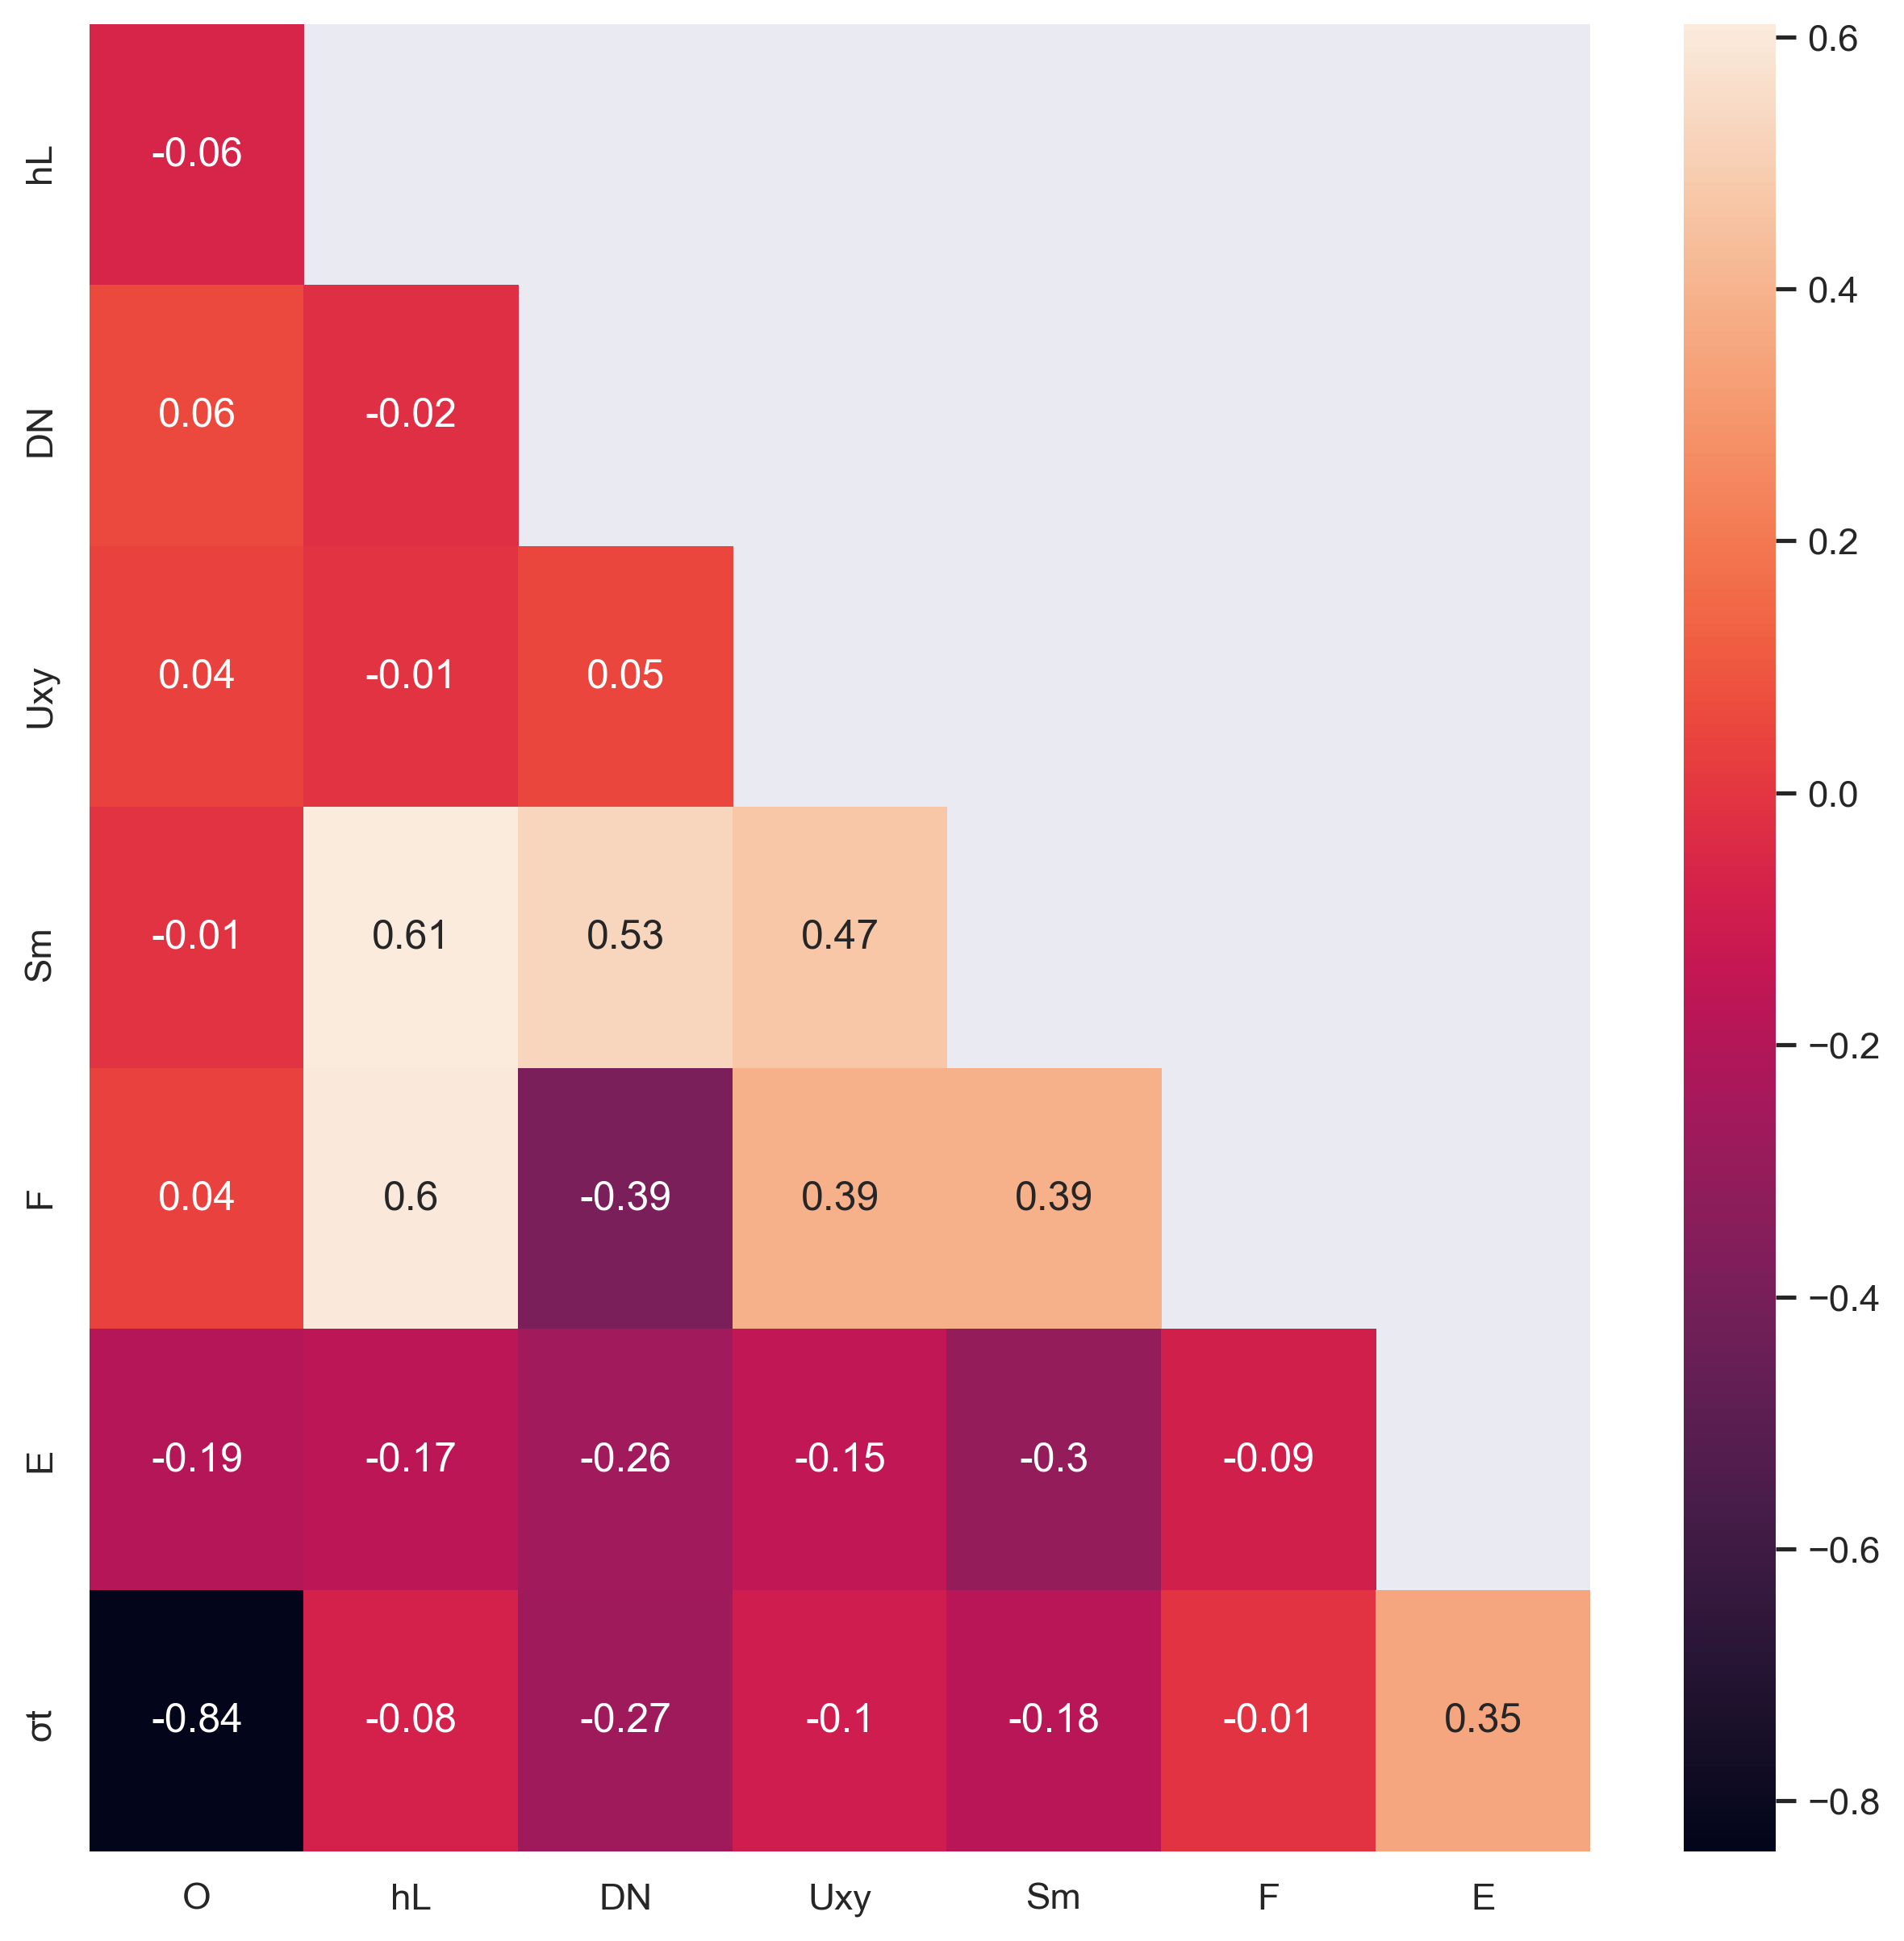

In [10]:

# Set up the matplotlib figure
figure = plt.figure(figsize=(10, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data=corr, mask=mask, annot=True, fmt = '')


#sb.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           #vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
#plt.yticks(rotation=0)
#plt.show()

### Theoretical Filament Speed calculation

In [11]:
df["S_t"] = 4* df["hL"] * df["DN"] * df["Uxy"] / (np.pi* (1.75**2)*60)
df["Sr"] = df['Sm']/df['S_t'] 
df.head()

,O,hL,DN,Uxy,Sm,F,E,σt,S_t,Sr
0,0,0.1,0.3,1200,0.36,870.77,2515.99,38.84,0.249451,1.443169
1,0,0.1,0.3,1200,0.43,870.32,2343.66,39.45,0.249451,1.723785
2,0,0.1,0.3,1200,0.24,826.45,2654.49,39.62,0.249451,0.962113
3,0,0.1,0.3,1200,0.24,793.59,2273.61,39.34,0.249451,0.962113
4,0,0.1,0.3,1200,0.24,793.59,3208.57,40.65,0.249451,0.962113


In [12]:
df_mod = df.drop(columns=['Sm', 'S_t'])
df_mod.head()

,O,hL,DN,Uxy,F,E,σt,Sr
0,0,0.1,0.3,1200,870.77,2515.99,38.84,1.443169
1,0,0.1,0.3,1200,870.32,2343.66,39.45,1.723785
2,0,0.1,0.3,1200,826.45,2654.49,39.62,0.962113
3,0,0.1,0.3,1200,793.59,2273.61,39.34,0.962113
4,0,0.1,0.3,1200,793.59,3208.57,40.65,0.962113


In [14]:
df_modd = df_mod.iloc[:,[0,1,2,3,7,4,5,6]]

In [17]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
# Compute the correlation matrix
correlation_matrix = df_modd.corr().round(2)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
mask = mask[1:, :-1]
corr = correlation_matrix.iloc[1:,:-1].copy()
corr


,O,hL,DN,Uxy,Sr,F,E
hL,-0.06,1.00,-0.02,-0.01,-0.19,0.60,-0.17
DN,0.06,-0.02,1.00,0.05,-0.20,-0.39,-0.26
Uxy,0.04,-0.01,0.05,1.00,-0.49,0.39,-0.15
Sr,-0.33,-0.19,-0.20,-0.49,1.00,-0.26,0.31
F,0.04,0.60,-0.39,0.39,-0.26,1.00,-0.09
E,-0.19,-0.17,-0.26,-0.15,0.31,-0.09,1.00
σt,-0.84,-0.08,-0.27,-0.10,0.49,-0.01,0.35


In [18]:
corrnumpy = corr.to_numpy()
annot_label = []
for m1 in range(len(corrnumpy)):
    temp_array = []
    for m2 in range(len(corrnumpy[0])):
        if corrnumpy[m1][m2] < 0.0:
            str_temp = u"\u2212"+str((-1.0)*corrnumpy[m1][m2])
        else:
            str_temp = str(corrnumpy[m1][m2])
        temp_array.append(str_temp)
    annot_label.append(temp_array)
print(annot_label)

[['−0.06', '1.0', '−0.02', '−0.01', '−0.19', '0.6', '−0.17'], ['0.06', '−0.02', '1.0', '0.05', '−0.2', '−0.39', '−0.26'], ['0.04', '−0.01', '0.05', '1.0', '−0.49', '0.39', '−0.15'], ['−0.33', '−0.19', '−0.2', '−0.49', '1.0', '−0.26', '0.31'], ['0.04', '0.6', '−0.39', '0.39', '−0.26', '1.0', '−0.09'], ['−0.19', '−0.17', '−0.26', '−0.15', '0.31', '−0.09', '1.0'], ['−0.84', '−0.08', '−0.27', '−0.1', '0.49', '−0.01', '0.35']]


<AxesSubplot:>

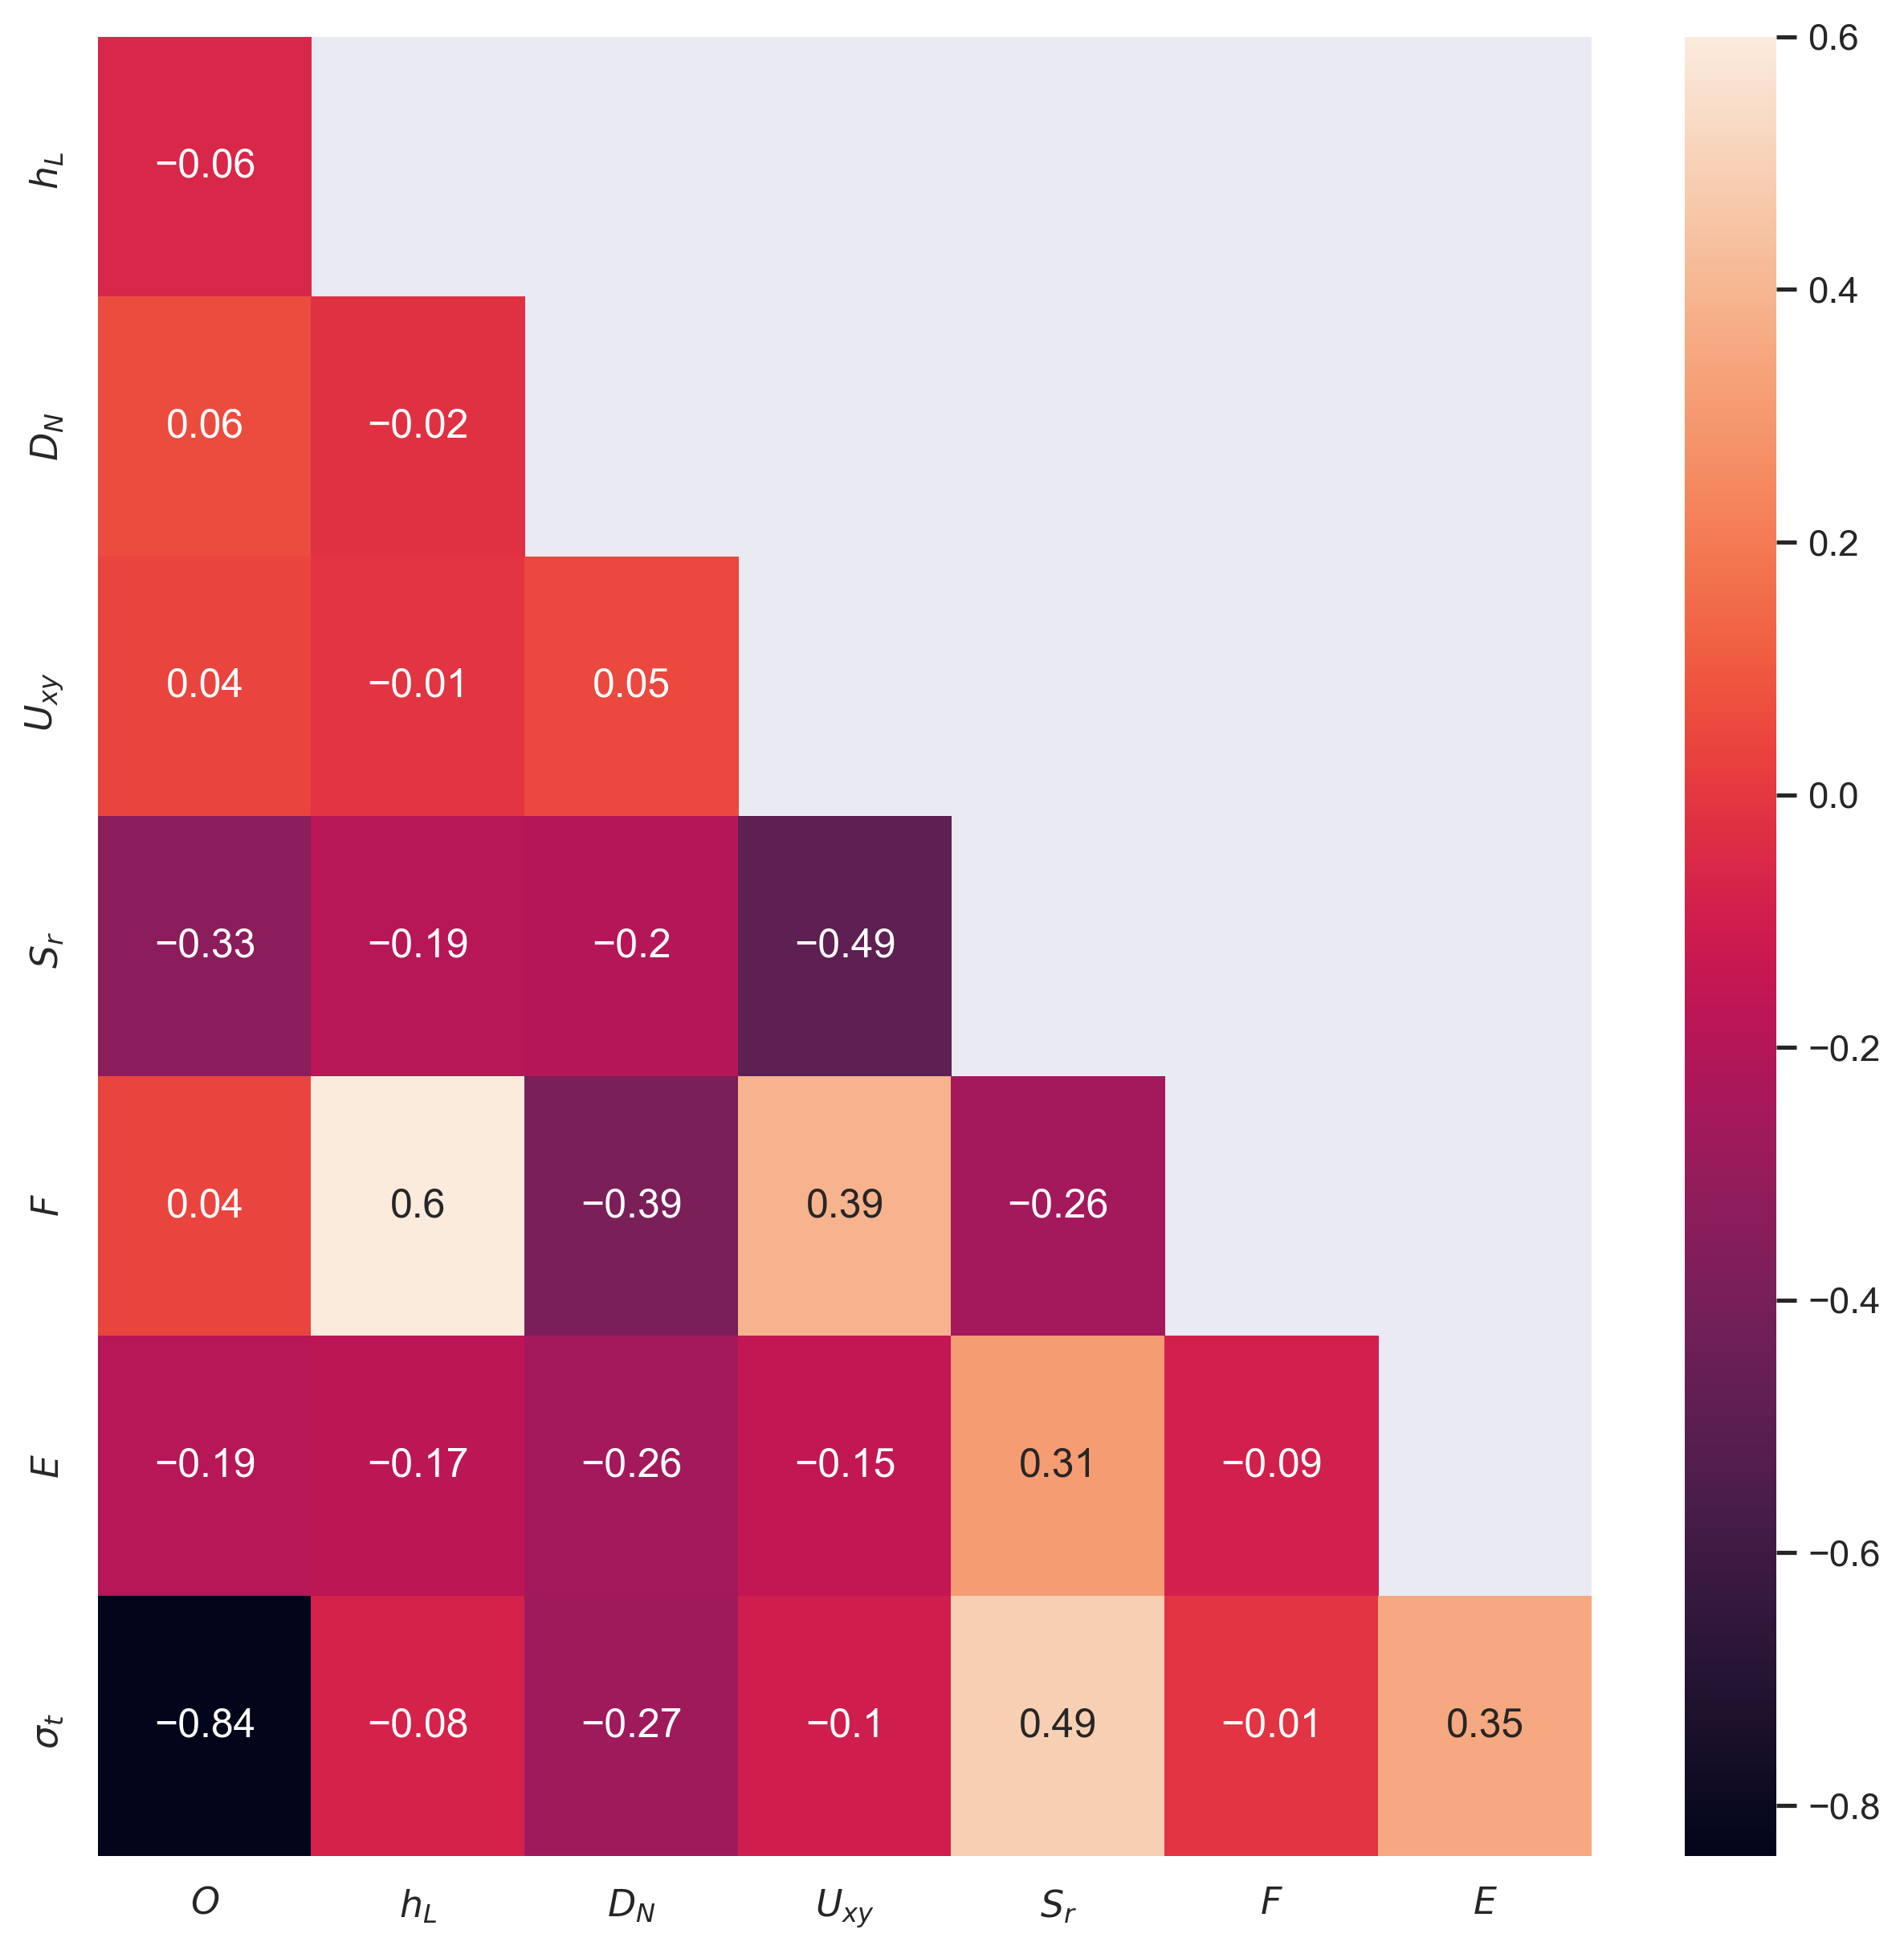

In [21]:
# Set up the matplotlib figure
figure = plt.figure(figsize=(10, 10))
label_x = ['$O$','$h_{L}$','$D_{N}$','$U_{xy}$','$S_{r}$','$F$','$E$']
label_y = ['$h_{L}$','$D_{N}$','$U_{xy}$','$S_{r}$','$F$','$E$','$σ_{t}$']
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data=corr, mask=mask, annot=annot_label,xticklabels = label_x, yticklabels = label_y,fmt = '' )


#sb.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           #vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
#plt.yticks(rotation=0)
#plt.show()

# Data Distribution

In [ ]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
# from matplotlib.font_manager import FontProperties



# matplotlib.rcParams['mathtext.fontset'] = 'custom'
# matplotlib.rcParams['mathtext.rm'] = 'Arial'
# matplotlib.rcParams['mathtext.it'] = 'Arial'

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
#sns.set(style="darkgrid")

sns.histplot(data=df_mod , x="F", color="gold", label="Extrusion Force", kde=True)
sns.histplot(data=df_mod , x="E", color="teal", label="Modulus", kde=True)
sns.histplot(data=df_mod , x="σt", color="olive", label="σt", kde=True)
#plt.xscale('log')
plt.xlabel('values')
plt.legend() 
plt.show()

In [ ]:
sns.histplot(data=df_mod , x="Uxy", color="gold", label="Printing Speed")
sns.histplot(data=df_mod , x="hL", color="green", label="Layer Heights")
sns.histplot(data=df_mod , x="DN", color="blue", label="Nozzle Diameter")
sns.histplot(data=df_mod , x="S_r", color="red", label="Speed Ratio", kde=True)
plt.xscale('log')
plt.xlabel('values')
plt.legend() 
plt.show()

In [ ]:
# sns.histplot(data=df_mod , x="LH", color="green", label="Layer Heights")
# sns.histplot(data=df_mod , x="ND", color="blue", label="Nozzle Diameter")
# sns.histplot(data=df_mod , x="S_r", color="red", label="Speed Ratio", kde=True)
# #plt.xscale('log')
# plt.xlabel('values')
# plt.legend() 
# plt.show()

## Creating the training and testing dataset

In [ ]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(df_mod, df_mod["O"]):
    strat_train_set = df_mod.loc[train_index]
    strat_test_set = df_mod.loc[test_index]

### Defining helper functions
In order to fulfill the requirement of the output format for regressors, the three columns of output were appended together to be a 476x3 matrix.

In [ ]:
#OUTPUT FORMATTING
def format_output(data):
    y1 = data.pop('F')
    y1 = np.array(y1)
    y2 = data.pop('E')
    y2 = np.array(y2)
    y3 = data.pop('σt')
    y3 = np.array(y3)
    Y = np.append(np.append([y1],[y2], axis=0),[y3], axis=0)
    Y = Y.transpose()
    return Y

In [ ]:
train_Y = format_output(strat_train_set)
test_Y = format_output(strat_test_set)
train_X = np.array(strat_train_set)
test_X = np.array(strat_test_set)
print(train_X)
#train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

## Set up pipelines for GridSearchCV with different regressors

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
#from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#from sklearn.neighbors import KDTree
#from sklearn.neighbors import BallTree
#from sklearn.preprocessing import PolynomialFeatures
#from sklearn.linear_model import Lasso
#from sklearn.linear_model import LogisticRegression

### A SVR pipeline based on MultiOutput Regressor

In [ ]:
#sklearn.metrics.get_scorer_names()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
pipe_svr = Pipeline([('scl', StandardScaler()),
        ('reg', MultiOutputRegressor(SVR()))])
param_grid = { 'reg__estimator__C':[0.1,1,100,1000],
              'reg__estimator__kernel':['rbf','sigmoid','linear'],
              'reg__estimator__gamma': np.logspace(-2, 2, 5)}
gs_svr = GridSearchCV(estimator=pipe_svr, 
                      param_grid=param_grid, 
                      cv=5,
                      n_jobs = -1)

gs_svr = gs_svr.fit(train_X,train_Y)
#

In [ ]:
print(gs_svr.best_params_)

In [ ]:
y_true, y_pred = test_Y, gs_svr.predict(test_X)
print("y1 RMSE:%.4f" % mean_squared_error(y_true[:,0], y_pred[:,0], squared = False))
print("y2 RMSE:%.4f" % mean_squared_error(y_true[:,1], y_pred[:,1], squared = False))
print("y3 RMSE:%.4f" % mean_squared_error(y_true[:,2], y_pred[:,2], squared = False))

In [ ]:

y_true, y_pred = test_Y, gs_svr.predict(test_X)
r2_score(y_true, y_pred,multioutput = 'raw_values')


In [ ]:
#plt.rcParams['font.family'] = 'Arial'
#rcParams['mathtext.rm'] = 'Arial'
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred, alpha= 0.5, color = '#ba423a')
    plt.title(title)
    plt.xlabel('True Values',fontname='Arial', fontsize=20)
    #ax.set_ylabel("Median Population", )
    plt.ylabel('Predictions', fontname='Arial', fontsize=20)
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.title(title, fontsize = 20)
    plt.plot([-10000, 10000], [-10000, 10000],'#f51607') 
    plt.rcParams['figure.dpi'] = 300
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=16)
    plt.rcParams["figure.autolayout"] = True

    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 0.8
    ax = plt.gca()
    ax.set_facecolor("white")
    plt.show()
    savefig('demo.png', transparent=True)

In [ ]:
plot_diff(y_true[:,0], y_pred[:,0], title='F')
plot_diff(y_true[:,1], y_pred[:,1], title='E')
plot_diff(y_true[:,2], y_pred[:,2], title='σ\u209C')

# Shap Value for SVR

In [ ]:
shap.initjs()

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(gs_svr.predict, train_X[:100], link = "identity")
shap_values = explainer.shap_values(train_X[100:200])

In [ ]:
# plot the SHAP values for the Setosa output of the first instance

shap.force_plot(explainer.expected_value[0], shap_values[1], train_X[100:200])

In [ ]:
shap.summary_plot(shap_values[0], train_X, feature_names = ["O", "LH", "ND", "PS", "S_r"],
                  plot_type="bar", class_names= ["F", "E", "TS"], show=False)
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontname='Arial', fontsize=18)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.rcParams["figure.autolayout"] = True
ax = plt.gca()
ax.set_facecolor("white")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.8

plt.rcParams['figure.dpi'] = 300
plt.show()

In [ ]:
shap.summary_plot(shap_values[1], train_X, feature_names = ["O", "LH", "ND", "PS", "S_r"],
                  plot_type="bar", class_names= ["F", "E", "TS"], show=False)
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontname='Arial', fontsize=18)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.rcParams["figure.autolayout"] = True
ax = plt.gca()
ax.set_facecolor("white")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.8
plt.rcParams['figure.dpi'] = 300
plt.show()

In [ ]:
shap.summary_plot(shap_values[2], train_X, feature_names = ["O", "LH", "ND", "PS", "S_r"],
                  plot_type="bar", class_names= ["F", "E", "TS"], show=False)
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontname='Arial', fontsize=18)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.rcParams["figure.autolayout"] = True
ax = plt.gca()
ax.set_facecolor("white")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.8
plt.rcParams['figure.dpi'] = 300
plt.show()

### A pipeline with a couple of different regressor which supports to multiple outputs

In [ ]:
FFF_pipeline = Pipeline([

    # scaler
    ('scaler', StandardScaler()),
    # Regression
    ('regressor', KNeighborsRegressor())

])

#parameter grid
param_grid = [{'regressor': [KNeighborsRegressor()],
               'regressor__n_neighbors':[5,6,7,8,9,10,11], 
               'scaler': [StandardScaler(), RobustScaler()]},
              {'regressor': [DecisionTreeRegressor()],
               'regressor__max_depth': [2, 3, 4],
                'scaler': [StandardScaler(), RobustScaler()]},
              {'regressor': [KernelRidge(kernel="rbf", gamma=0.1)],
               'regressor__alpha': [1e0, 0.1, 1e-2, 1e-3],
               'regressor__gamma': np.logspace(-2, 2, 5),
               'scaler': [StandardScaler(), RobustScaler()]}   
             ]

In [ ]:
#Building and testing the model         
gs_pipe = GridSearchCV(FFF_pipeline, 
                       param_grid, 
                       #scoring='neg_root_mean_squared_error', 
                       cv=5, 
                       n_jobs=-1)

gs_pipe.fit(train_X, train_Y)

 

In [ ]:
print(gs_pipe.best_params_)

In [ ]:
y_true_2, y_pred_2 = test_Y, gs_pipe.predict(test_X)
print("y1 RMSE:%.4f" % mean_squared_error(y_true_2[:,0], y_pred_2[:,0], squared = False))
print("y2 RMSE:%.4f" % mean_squared_error(y_true_2[:,1], y_pred_2[:,1], squared = False))
print("y3 RMSE:%.4f" % mean_squared_error(y_true_2[:,2], y_pred_2[:,2], squared = False))

In [ ]:

r2_score(y_true_2, y_pred_2,multioutput = 'raw_values')

In [ ]:
plot_diff(y_true_2[:,0], y_pred_2[:,0], title='F')
plot_diff(y_true_2[:,1], y_pred_2[:,1], title='E')
plot_diff(y_true_2[:,2], y_pred_2[:,2], title='σ\u209C')

# Shap Value for KRR

In [ ]:
shap.initjs()

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(gs_pipe.predict, train_X[:100], link = "identity")
shap_values_krr = explainer.shap_values(train_X[100:200])

# plot the SHAP values for the Setosa output of the first instance

shap.force_plot(explainer.expected_value[0], shap_values[1], train_X[100:200])

In [ ]:
shap.summary_plot(shap_values_krr[0], train_X, feature_names = ["O", "LH", "ND", "PS", "S_r"],
                  plot_type="bar", class_names= ["F", "E", "TS"], show=False)
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontname='Arial', fontsize=18)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.rcParams["figure.autolayout"] = True
ax = plt.gca()
ax.set_facecolor("white")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.8
plt.rcParams['figure.dpi'] = 300
plt.show()

In [ ]:
shap.summary_plot(shap_values_krr[1], train_X, feature_names = ["O", "LH", "ND", "PS", "S_r"],
                  plot_type="bar", class_names= ["F", "E", "TS"], show=False)
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontname='Arial', fontsize=18)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.rcParams["figure.autolayout"] = True
ax = plt.gca()
ax.set_facecolor("white")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.8
plt.rcParams['figure.dpi'] = 300
plt.show()

In [ ]:
shap.summary_plot(shap_values_krr[2], train_X, feature_names = ["O", "LH", "ND", "PS", "S_r"],
                  plot_type="bar", class_names= ["F", "E", "TS"], show=False)
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontname='Arial', fontsize=18)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.rcParams["figure.autolayout"] = True
ax = plt.gca()
ax.set_facecolor("white")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.8
plt.rcParams['figure.dpi'] = 300
plt.show()

## Validation

In [ ]:
FC = pd.read_csv('verification_data_input')
FC.head()


In [ ]:
FC = np.array(FC)
FC

In [ ]:
KRR = gs_pipe.predict(FC)
KRR

In [ ]:
SVR = gs_svr.predict(FC)
SVR

In [ ]:
exp = pd.read_csv('verification_data_exp result.csv')
exp = np.array(exp)
exp

In [ ]:
r_error_SVR = np.abs(SVR - exp)/exp
r_error_SVR = r_error_SVR.transpose()
r_error_SVR

In [ ]:
r_error_KRR = np.abs(KRR - exp)/exp
r_error_KRR = r_error_KRR.transpose()
r_error_KRR

In [ ]:
r_error_ANN = np.array([[0.239, 0.211, 0.224, 0.246, 0.323, 0.32 , 0.341, 0.347],[0.077, 0.051, 0.097, 0.044, 0.092, 0.074, 0.028, 0.107],[0.125, 0.123, 0.098, 0.08 , 0.106, 0.111, 0.078, 0.077]])
r_error_ANN

In [ ]:
x = np.array([1,2,3,4,5,6,7,8])
# plot lines
plt.plot(x, r_error_ANN[0,:], label = "ANN_RMSE")
plt.plot(x, r_error_KRR[0,:], label = "KRR_RMSE")
plt.plot(x, r_error_SVR[0,:], label = "SVR_RMSE")
plt.xlabel('sample number',fontname='Arial', fontsize=12)
plt.ylabel('RMSE',fontname='Arial', fontsize=12)
plt.title('F', fontsize = 20)
#plt.plot([-10000, 10000], [-10000, 10000],'#f51607') 
plt.rcParams['figure.dpi'] = 300
plt.xticks(fontsize=15)
plt.yticks(fontsize=16)
# plt.rcParams["figure.autolayout"] = True
# plt.rcParams["axes.edgecolor"] = "black"
# plt.rcParams["axes.linewidth"] = 0.8
ax = plt.gca()
ax.set_facecolor("white")
plt.legend(framealpha=0)
plt.show()

In [ ]:
x = np.array([1,2,3,4,5,6,7,8])
# plot lines
plt.plot(x, r_error_ANN[1,:], label = "ANN_RMSE")
plt.plot(x, r_error_KRR[1,:], label = "KRR_RMSE")
plt.plot(x, r_error_SVR[1,:], label = "SVR_RMSE")
plt.xlabel('sample number',fontname='Arial', fontsize=12)
plt.ylabel('RMSE',fontname='Arial', fontsize=12)

plt.title('E', fontsize = 20)
#plt.plot([-10000, 10000], [-10000, 10000],'#f51607') 
plt.rcParams['figure.dpi'] = 300
plt.xticks(fontsize=15)
plt.yticks(fontsize=16)
# plt.rcParams["figure.autolayout"] = True
# plt.rcParams["axes.edgecolor"] = "black"
# plt.rcParams["axes.linewidth"] = 0.8
ax = plt.gca()
ax.set_facecolor("white")
plt.legend(framealpha=0)
plt.show()
plt.rcParams['figure.dpi'] = 300

In [ ]:
x = np.array([1,2,3,4,5,6,7,8])
# plot lines
plt.plot(x, r_error_ANN[2,:], label = "ANN_RMSE")
plt.plot(x, r_error_KRR[2,:], label = "KRR_RMSE")
plt.plot(x, r_error_SVR[2,:], label = "SVR_RMSE")
plt.xlabel('sample number',fontname='Arial', fontsize=12)
plt.ylabel('RMSE',fontname='Arial', fontsize=12)

plt.title('σ\u209C', fontsize = 20)
#plt.plot([-10000, 10000], [-10000, 10000],'#f51607') 
plt.rcParams['figure.dpi'] = 300
plt.xticks(fontsize=15)
plt.yticks(fontsize=16)
# plt.rcParams["figure.autolayout"] = True
# plt.rcParams["axes.edgecolor"] = "black"
# plt.rcParams["axes.linewidth"] = 0.8
ax = plt.gca()
ax.set_facecolor("white")
plt.legend(framealpha=0)
plt.show()
plt.rcParams['figure.dpi'] = 300

In [ ]:
VF1 = pd.read_csv('verification_data_speed.csv')
#sns.boxplot(x=VF["S_r"])
VF2 = pd.read_csv('verification_data_ prediction outputs.csv')
VF2.loc[16:23, 'Labels'] = 'σt'
VF1

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 300
sns.set(font_scale=2)
sns.set_style("ticks")

fig, axs = plt.subplots(ncols=2)
my_pal1 = {"Usz": "lightcoral", "S_r": "brown"}
sns.boxplot(data=VF1[0:8], x='Labels', y = 'Values', palette=my_pal1,width = 0.5, linewidth = 1, ax=axs[0])
sns.boxplot(data=VF1[8:16], x='Labels', y = 'Values', palette=my_pal1,width = 0.5, linewidth = 1, ax=axs[1])

fig.suptitle('Filament Speed and Ratio Distribution', fontdict={'size': 24})
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 300
sns.set(font_scale=2)
sns.set_style("ticks")
my_pal2 = {"F": "lightsteelblue", "E": "cornflowerblue", "σt":"royalblue"}
fig, axs = plt.subplots(ncols=3)
sns.boxplot(data=VF2[0:8], x='Labels', y = 'Values', palette=my_pal2,width = 0.5, linewidth = 1, ax=axs[0])
sns.boxplot(data=VF2[8:16], x='Labels', y = 'Values', palette=my_pal2,width = 0.5, linewidth = 1, ax=axs[1])
sns.boxplot(data=VF2[16:], x='Labels', y = 'Values', palette=my_pal2,width = 0.5, linewidth = 1, ax=axs[2])
fig.suptitle('Model Outputs Distribution', fontdict={'size': 24})
plt.show()

In [ ]:
svr 0.909, 0.346, 0.974
knn 0.907, 0.163, 0.93
ann 0.807, 0.184, 0.8545
rsm 0.841, 0.295, 0.933

In [ ]:
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 300
sns.set(font_scale=2)
sns.set_style("ticks")
my_pal2 = {"F": "orange", "E": "olivedrab", "σt":"sienna"}
fig, axs = plt.subplots(ncols=2)
sns.boxplot(data=VF2[0:8], x='Labels', y = 'Values', palette=my_pal2,width = 0.5, linewidth = 1, ax=axs[0])
sns.boxplot(data=VF2[8:16], x='Labels', y = 'Values', palette=my_pal2,width = 0.5, linewidth = 1, ax=axs[1])

fig.suptitle('Filament Speed and Ratio Distribution', fontdict={'size': 24})
plt.show()